# Data Augmentation

In [1]:
import json
import random
import logging

from tqdm import tqdm
import itertools as it
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ataarangi.utils import multicore_apply
from ataarangi.data import māori_colour_map, MĀORI_COLOURS
from ataarangi.rakau import WorldState, Rākau

tqdm.pandas()

In [2]:
json_data = []
world_states = []
with open('../data/world_states.jsonl', 'r') as f:
    for line in f.readlines():
        j = json.loads(line)
        json_data.append(j)
        world_states.append(
            WorldState.from_dict(j['sticks'])
        )

rākau_data = pd.read_csv('../data/rākau_data.csv')

ngā rākau


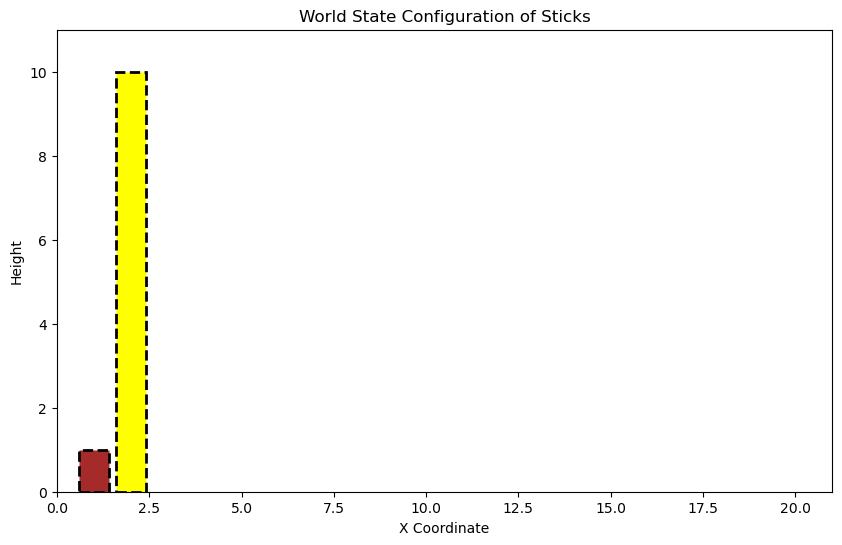

In [3]:
index = 12 
state = WorldState.from_dict(json_data[index]['sticks'])
print(rākau_data.loc[index, 'description'])
state.draw()

Based on this plot, it's probably enough to filter out samples with more than 10 sticks as being 'too complicated'. That'll help us keep the feature matrices compact, which hopefully will help with learning.

## Symmetries

There are multiple symmetries in this game. We could use these to augment the training data and hopefully teach the model some useful invariances relating to the target task. The goal will be to implement these in this notebook.

The symmetries are:
- Colour: For a given world state, if you permute the colours in the input and permute the colours in the output in the same way, then the resulting (world state, utterance) pair will still be valid.
- Size: The size is an ordinal variable, so as long as the sizes of the sticks are in the same relative order, the target utterance should not change.
- Position: Unless the words "Left" or "Right" are used, the order of the sticks does not matter (this could be false, strictly speaking since putting the sticks all on one side may change the most natural utterance)
- Reflection: If the words "Left" or "Right" are used, then if you reverse the order of the sticks, the target utterance will be valid after substituting "Right" for "Left" and vice-versa.

### Colour

We'll start by exploring colour, and we'll do this by calculating the set of all possible permutations of the available colours. Once we have that, we can choose all permutations that move at least one of the colours in the world state, and then we can apply all of those maps in the input and output to get every possible colour permutation of this world state.

In [4]:
from ataarangi.data import COLOURS
import itertools as it

In [5]:
colour_to_id = dict(zip(COLOURS, range(len(COLOURS))))
id_to_colour = {v: k for k, v in colour_to_id.items()}
colour_to_id, id_to_colour

({'red': 0,
  'blue': 1,
  'green': 2,
  'yellow': 3,
  'black': 4,
  'white': 5,
  'brown': 6,
  'pink': 7},
 {0: 'red',
  1: 'blue',
  2: 'green',
  3: 'yellow',
  4: 'black',
  5: 'white',
  6: 'brown',
  7: 'pink'})

In [6]:
def create_permutation_matrix(elements):
    # Generate all permutations of the array of colors
    elem_indices = np.arange(len(elements))
    all_perms = list(it.permutations(elem_indices))
    num_perms = len(all_perms)
    
    # Create a 3D array to hold the permutation transformation matrices
    transformation_tensor = np.zeros((num_perms, len(elements), len(elements)), dtype=int)
    
    for i, perm in enumerate(all_perms):
        # Fill the appropriate places in the matrix to indicate the movement
        transformation_tensor[i, elem_indices, perm] = 1

    return transformation_tensor

In [7]:
# Example usage
num_colors = len(COLOURS)  # Small example with 4 colors
permutation_matrix = create_permutation_matrix(COLOURS)

In [8]:
# Find all permutations where at least one colour in state.colors moves
colour_indices = sorted([colour_to_id[col] for col in state.colors.keys()])

perms = np.unique(
    np.where(
        permutation_matrix[:, colour_indices, colour_indices] == 0
        )[0]
)

perms

array([    1,     2,     3, ..., 40317, 40318, 40319])

In [9]:
len(perms)

39600

So now that I have the table of permutations that move at least one of the blocks in the target set, I should use it to generate all of the world states corresponding to the table. Then, I take the given utterance for that world state, identify the bits that matter and permute them according to some rules.

So I need a function that given a permutation matrix, computes the bijection that it represents. The output should be a dictionary that maps input colours to target colours.

In [10]:
# Get the mapping corresponding to a permutation matrix
dict(zip(COLOURS, [COLOURS[idx] for idx in np.where(permutation_matrix[123])[1]]))

{'red': 'red',
 'blue': 'blue',
 'green': 'yellow',
 'yellow': 'green',
 'black': 'black',
 'white': 'brown',
 'brown': 'pink',
 'pink': 'white'}

Now that I have the bijection, I should probably package it into a function and then use it to generate permutations on the fly.

In [11]:
def generate_colour_permutations(indices, elements=COLOURS):
    '''
    Generate all permutations of an array of unique elements of a given length, and filter
    such that each permutation moves at least one of the elements in `indices`.
    '''
    permutation_matrix = create_permutation_matrix(elements)
    permutations = [dict(zip(elements, [elements[idx] for idx in np.where(perm)[1]])) for perm in permutation_matrix]
    permutations = [{k: v for k, v in d.items() if colour_to_id[k] in indices} for d in permutations]
    return [dict(t) for t in {tuple(d.items()) for d in permutations}]


In [12]:
colour_indices, COLOURS

([3, 6], ['red', 'blue', 'green', 'yellow', 'black', 'white', 'brown', 'pink'])

So we have all of the mappings that move at least one element we care about. Now we need to take a given world state, and generate all of its permutations and then use the token mapping to permute the utterance in the same way.

In [13]:
state_colors = [colour_to_id[rākau.color] for rākau in state.ngā_rākau]
generated_permutations = generate_colour_permutations(state_colors, COLOURS)
generated_permutations

[{'yellow': 'red', 'brown': 'brown'},
 {'yellow': 'green', 'brown': 'white'},
 {'yellow': 'yellow', 'brown': 'white'},
 {'yellow': 'green', 'brown': 'black'},
 {'yellow': 'blue', 'brown': 'pink'},
 {'yellow': 'yellow', 'brown': 'black'},
 {'yellow': 'white', 'brown': 'pink'},
 {'yellow': 'black', 'brown': 'yellow'},
 {'yellow': 'green', 'brown': 'brown'},
 {'yellow': 'white', 'brown': 'blue'},
 {'yellow': 'yellow', 'brown': 'brown'},
 {'yellow': 'brown', 'brown': 'pink'},
 {'yellow': 'brown', 'brown': 'blue'},
 {'yellow': 'pink', 'brown': 'blue'},
 {'yellow': 'red', 'brown': 'green'},
 {'yellow': 'green', 'brown': 'red'},
 {'yellow': 'white', 'brown': 'yellow'},
 {'yellow': 'blue', 'brown': 'yellow'},
 {'yellow': 'yellow', 'brown': 'red'},
 {'yellow': 'black', 'brown': 'white'},
 {'yellow': 'brown', 'brown': 'yellow'},
 {'yellow': 'pink', 'brown': 'yellow'},
 {'yellow': 'yellow', 'brown': 'green'},
 {'yellow': 'black', 'brown': 'brown'},
 {'yellow': 'red', 'brown': 'pink'},
 {'yellow':

So now we have all of the permutations of the colour set. We can now look at size, position and reflection.

Permuting the size is tricky because it needs to preserve the order. We 

In [14]:
def generate_size_permutations(sizes, min_size, max_size):
    """
    Generate all order-preserving permutations of sizes within a given range.

    Args:
        sizes (list of int): Original sizes of the sticks.
        min_size (int): Minimum allowable size.
        max_size (int): Maximum allowable size.

    Returns:
        list of list: All valid permutations of sizes maintaining the original order.
    """
    min_current = min(sizes)
    max_current = max(sizes)
    
    max_down_shift = min_current - min_size
    max_up_shift = max_size - max_current
    
    permutations = []
    
    # Generate shifts from -max_down_shift to max_up_shift
    for shift in range(-max_down_shift, max_up_shift + 1):
        new_sizes = [size + shift for size in sizes]
        permutations.append(new_sizes)
    
    return [dict(zip(sizes, perm)) for perm in permutations]

def generate_ordered_size_permutations(sizes, min_size, max_size):
    length = len(set(sizes))
    sizes = list(set(sizes))
    from itertools import combinations

    # Generate all possible unique ordered combinations of sizes
    # within the given range that preserve order.
    all_sizes = range(min_size, max_size + 1)
    size_map = [dict(zip(range(length), comb)) for comb in combinations(all_sizes, length)]
    return [{sizes[k]: v for k, v in d.items()} for d in size_map]

In [15]:
# Example usage:
sizes = [1, 4, 5]
min_size = 1
max_size = 10
permutations = generate_size_permutations(sizes, min_size, max_size)
print(permutations)

[{1: 1, 4: 4, 5: 5}, {1: 2, 4: 5, 5: 6}, {1: 3, 4: 6, 5: 7}, {1: 4, 4: 7, 5: 8}, {1: 5, 4: 8, 5: 9}, {1: 6, 4: 9, 5: 10}]


Ok that's a reasonable way to do it. The next thing is location, which we can do with regular permutation.

In [16]:
locations = [r.location for r in state.ngā_rākau]
locations

[1, 2]

For the location, rather than generate potentially a very large number of permutations we can just sample n shuffles from the same set and take the unique ones.

Okay, so we need to start folding these things together. We make a function, pass it a world state, utterance pair and it should produce a list of permuted world state, utterance pairs. Internally, it needs to compute:
- The permutations of the colour set for that world state
- The order preserving permutations of the size set
- A randomly sampled set of positions (with a flag to turn this feature off)

Then once it has those mappings, it needs to apply the colour map to the utterance and return the world state corresponding to that permutation as well (for tokenization).

In [17]:
state.ngā_rākau

[Rākau(color=brown, height=1, location=1, selected=True),
 Rākau(color=yellow, height=10, location=2, selected=True)]

In [18]:
state_colours = [colour_to_id[r.color] for r in state.ngā_rākau]
state_colours

[6, 3]

In [19]:
colour_permutations = generate_colour_permutations(state_colors)
colour_permutations[:10]

[{'yellow': 'red', 'brown': 'brown'},
 {'yellow': 'green', 'brown': 'white'},
 {'yellow': 'yellow', 'brown': 'white'},
 {'yellow': 'green', 'brown': 'black'},
 {'yellow': 'blue', 'brown': 'pink'},
 {'yellow': 'yellow', 'brown': 'black'},
 {'yellow': 'white', 'brown': 'pink'},
 {'yellow': 'black', 'brown': 'yellow'},
 {'yellow': 'green', 'brown': 'brown'},
 {'yellow': 'white', 'brown': 'blue'}]

In [20]:
state_sizes = [r.height for r in state.ngā_rākau]
state_sizes

[1, 10]

In [21]:
state_sizes

[1, 10]

In [22]:
size_permutations = generate_ordered_size_permutations(state_sizes, 1, 10)
size_permutations

[{1: 1, 10: 2},
 {1: 1, 10: 3},
 {1: 1, 10: 4},
 {1: 1, 10: 5},
 {1: 1, 10: 6},
 {1: 1, 10: 7},
 {1: 1, 10: 8},
 {1: 1, 10: 9},
 {1: 1, 10: 10},
 {1: 2, 10: 3},
 {1: 2, 10: 4},
 {1: 2, 10: 5},
 {1: 2, 10: 6},
 {1: 2, 10: 7},
 {1: 2, 10: 8},
 {1: 2, 10: 9},
 {1: 2, 10: 10},
 {1: 3, 10: 4},
 {1: 3, 10: 5},
 {1: 3, 10: 6},
 {1: 3, 10: 7},
 {1: 3, 10: 8},
 {1: 3, 10: 9},
 {1: 3, 10: 10},
 {1: 4, 10: 5},
 {1: 4, 10: 6},
 {1: 4, 10: 7},
 {1: 4, 10: 8},
 {1: 4, 10: 9},
 {1: 4, 10: 10},
 {1: 5, 10: 6},
 {1: 5, 10: 7},
 {1: 5, 10: 8},
 {1: 5, 10: 9},
 {1: 5, 10: 10},
 {1: 6, 10: 7},
 {1: 6, 10: 8},
 {1: 6, 10: 9},
 {1: 6, 10: 10},
 {1: 7, 10: 8},
 {1: 7, 10: 9},
 {1: 7, 10: 10},
 {1: 8, 10: 9},
 {1: 8, 10: 10},
 {1: 9, 10: 10}]

In [23]:
state_locations = [r.location for r in state.ngā_rākau]
print(state_locations)

[1, 2]


In [24]:
location_permutations = sorted(set(tuple(random.choices(range(10), k=len(state_locations))) for _ in range(50)))
location_permutations = [dict(zip(range(1, len(d)+1), d)) for d in location_permutations]
location_permutations

[{1: 0, 2: 3},
 {1: 0, 2: 5},
 {1: 0, 2: 8},
 {1: 0, 2: 9},
 {1: 1, 2: 1},
 {1: 1, 2: 3},
 {1: 1, 2: 4},
 {1: 1, 2: 5},
 {1: 1, 2: 6},
 {1: 1, 2: 9},
 {1: 2, 2: 0},
 {1: 2, 2: 2},
 {1: 2, 2: 8},
 {1: 2, 2: 9},
 {1: 3, 2: 0},
 {1: 3, 2: 4},
 {1: 3, 2: 5},
 {1: 3, 2: 7},
 {1: 4, 2: 0},
 {1: 4, 2: 1},
 {1: 4, 2: 4},
 {1: 4, 2: 5},
 {1: 5, 2: 0},
 {1: 5, 2: 1},
 {1: 5, 2: 6},
 {1: 5, 2: 7},
 {1: 6, 2: 3},
 {1: 6, 2: 6},
 {1: 6, 2: 7},
 {1: 6, 2: 9},
 {1: 7, 2: 2},
 {1: 7, 2: 4},
 {1: 7, 2: 7},
 {1: 8, 2: 2},
 {1: 8, 2: 5},
 {1: 8, 2: 7},
 {1: 8, 2: 8},
 {1: 9, 2: 2},
 {1: 9, 2: 6},
 {1: 9, 2: 7}]

Now we need to generate the world states corresponding to the product of all of these permutations.

In [25]:
states = []
for colour_map, size_map, location_map in it.product(colour_permutations, size_permutations, location_permutations):
    ngā_rākau = []
    for rākau in state.ngā_rākau:
        ngā_rākau.append(
            Rākau(color=colour_map[rākau.color], height=size_map[rākau.height], location=location_map[rākau.location], selected=rākau.selected)
        )
    states.append(ngā_rākau)

Now we have an array with all of the states. We should roll this into a function that takes just the world state as input, and returns an array of world states.

In [26]:
def generate_rākau_permutations(state, description, sample_size=1000):

    tokens = description.split()
    
    state_colours = [colour_to_id[r.color] for r in state.ngā_rākau]
    state_sizes = [r.height for r in state.ngā_rākau]
    state_locations = [r.location for r in state.ngā_rākau]
    colour_permutations = generate_colour_permutations(state_colours)
    size_permutations = generate_ordered_size_permutations(state_sizes, 1, 10)

    results = []
    for _ in range(sample_size):
        colour_map = random.choice(colour_permutations)
        size_map = random.choice(size_permutations)

        if not any([side in tokens for side in ['māui', 'matau']]):
            location_map = dict(zip(range(1, len(state_locations)+1),
                                tuple(random.choices(range(10), k=len(state_locations)))))
        else:
            if random.random() > 0.5:
                # Keep the order
                location_map = dict(zip(range(1, len(state_locations)+1), range(1, len(state_locations)+1)))
            else:
                # Reverse the order
                location_map = dict(zip(range(1, len(state_locations)+1), list(range(1, len(state_locations)+1))[::-1]))
                tokens = ["māui" if token == 'matau' else 'matau' if token == 'māui' else token for token in tokens]
        
        translated_colour_map = {māori_colour_map[k]: māori_colour_map[v] for k, v in colour_map.items()}        
        translated_tokens = [token if not token in MĀORI_COLOURS else translated_colour_map[token] for token in tokens]
        
        ngā_rākau = WorldState()
        for rākau in state.ngā_rākau:
            ngā_rākau.add_rākau(
                Rākau(color=colour_map[rākau.color], height=size_map[rākau.height], location=location_map[rākau.location], selected=rākau.selected)
            )
        results.append({'state': ngā_rākau, 'description': ' '.join(translated_tokens)})

    return results


In [27]:
rākau_data

,id,entropy,num_rākau,rākau,description
0,800d23b5-574c-46d3-94cf-1066082e9d7d,3.0,2,"[{""color"": ""blue"", ""height"": 4, ""location"": 1,...",te rākau mā
1,659289fa-7473-4617-a8f0-61324cc0e3b1,2.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 1,...",ngā rākau
2,7629eca4-df36-4921-973b-0ca7859c5018,3.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 1,...",te rākau iti
3,89413927-94ca-4078-8198-85b957338400,3.0,2,"[{""color"": ""white"", ""height"": 8, ""location"": 1...",te rākau mā
4,eb110390-7be8-4d7a-93e0-211c33c033f1,3.0,2,"[{""color"": ""black"", ""height"": 10, ""location"": ...",ngā rākau
...,...,...,...,...,...
1012,3d543250-f7c8-47c4-9491-ab29d5c8c8fd,3.0,2,"[{""color"": ""black"", ""height"": 9, ""location"": 1...",te rākau kikorangi
1013,b6fcfe8b-5604-47d5-8e1a-1a2830219683,3.0,2,"[{""color"": ""white"", ""height"": 4, ""location"": 1...",te rākau mā
1014,ecc53392-b801-4159-8fe3-fe9475e50672,3.0,2,"[{""color"": ""red"", ""height"": 9, ""location"": 1, ...",te rākau whero
1015,bd1d8542-5e5f-4d03-9bf3-8b3d889fe737,3.0,2,"[{""color"": ""red"", ""height"": 10, ""location"": 1,...",ngā rākau


In [28]:
index = 123
state_2 = WorldState.from_dict(json_data[index]['sticks'])
print(rākau_data.loc[index, 'description'])
# state_2.draw()

te rākau māwhero me te rākau mā


In [29]:
%%time
generate_rākau_permutations(state_2, rākau_data.loc[index, 'description'])[:2]

CPU times: user 263 ms, sys: 8.48 ms, total: 271 ms
Wall time: 271 ms


[{'state': WorldState(Rākau(color=white, height=6, location=9, selected=False), Rākau(color=brown, height=4, location=3, selected=True), Rākau(color=green, height=4, location=4, selected=True)),
  'description': 'te rākau parauri me te rākau kākāriki'},
 {'state': WorldState(Rākau(color=green, height=7, location=0, selected=False), Rākau(color=red, height=2, location=9, selected=True), Rākau(color=yellow, height=2, location=0, selected=True)),
  'description': 'te rākau whero me te rākau kōwhai'}]

Okay, I'll use this trick to increase the amount of data 1,000 fold. Then, I'll train the model on the results. That will give me over 1 million samples.

In [30]:
%%time
rākau_data['permuted'] = multicore_apply( 
    rākau_data.apply(lambda x: {'state': WorldState.from_dict({'ngā_rākau': json.loads(x.rākau)}), 'description': x.description}, axis=1),
    generate_rākau_permutations,
    n_jobs=16,
    use_kwargs=True
)

100%|███████████████████████████████████████| 1017/1017 [00:36<00:00, 27.87it/s]


CPU times: user 15.3 s, sys: 976 ms, total: 16.3 s
Wall time: 36.7 s


In [31]:
rākau_data

,id,entropy,num_rākau,rākau,description,permuted
0,800d23b5-574c-46d3-94cf-1066082e9d7d,3.0,2,"[{""color"": ""blue"", ""height"": 4, ""location"": 1,...",te rākau mā,"[{'state': WorldState(Rākau(color=blue, height..."
1,659289fa-7473-4617-a8f0-61324cc0e3b1,2.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 1,...",ngā rākau,"[{'state': WorldState(Rākau(color=pink, height..."
2,7629eca4-df36-4921-973b-0ca7859c5018,3.0,2,"[{""color"": ""blue"", ""height"": 1, ""location"": 1,...",te rākau iti,"[{'state': WorldState(Rākau(color=red, height=..."
3,89413927-94ca-4078-8198-85b957338400,3.0,2,"[{""color"": ""white"", ""height"": 8, ""location"": 1...",te rākau mā,"[{'state': WorldState(Rākau(color=yellow, heig..."
4,eb110390-7be8-4d7a-93e0-211c33c033f1,3.0,2,"[{""color"": ""black"", ""height"": 10, ""location"": ...",ngā rākau,"[{'state': WorldState(Rākau(color=pink, height..."
...,...,...,...,...,...,...
1012,3d543250-f7c8-47c4-9491-ab29d5c8c8fd,3.0,2,"[{""color"": ""black"", ""height"": 9, ""location"": 1...",te rākau kikorangi,"[{'state': WorldState(Rākau(color=yellow, heig..."
1013,b6fcfe8b-5604-47d5-8e1a-1a2830219683,3.0,2,"[{""color"": ""white"", ""height"": 4, ""location"": 1...",te rākau mā,"[{'state': WorldState(Rākau(color=white, heigh..."
1014,ecc53392-b801-4159-8fe3-fe9475e50672,3.0,2,"[{""color"": ""red"", ""height"": 9, ""location"": 1, ...",te rākau whero,"[{'state': WorldState(Rākau(color=yellow, heig..."
1015,bd1d8542-5e5f-4d03-9bf3-8b3d889fe737,3.0,2,"[{""color"": ""red"", ""height"": 10, ""location"": 1,...",ngā rākau,"[{'state': WorldState(Rākau(color=white, heigh..."
